In [16]:
import docplex
import pandas as pd
import math
from docplex.mp.model import Model
import matplotlib.pyplot as plt

In [17]:
df = pd.read_excel('fake_cities4.xlsx')

In [18]:
df

,City_id,X,Y,Population
0,1,20.201549,52.824184,1568818
1,2,22.926474,52.110554,1637902
2,3,16.849968,49.437353,650715
3,4,21.874644,51.004260,1736267
4,5,16.810748,50.427237,1181010
...,...,...,...,...
695,696,16.011432,50.805608,1270816
696,697,16.611255,51.801909,1374094
697,698,20.442781,49.143153,512955
698,699,14.953345,53.297974,1385684


In [19]:
%%time

model = Model(name='Problem rozmieszczenia')

# data
data = list(df.to_records(index=False))

# Tworzenie zmiennych decyzyjnych
selected = model.binary_var_list(len(data), name='selected')

# Tworzenie funkcji celu
population = sum(selected[i] * (1 / ((data[i][1] - data[j][1])**2 + (data[i][2] - data[j][2])**2 + 1e-6)) * data[i][3]
                for i in range(len(data)) for j in range(len(data)))

model.maximize(population)

# Ograniczenie, tylko X punktów może być wybranych
model.add_constraint(model.sum(selected) == 10)

# Ograniczenie: Miasta blisko wybranych punktów nie są brane pod uwagę
for i in range(len(data)):
    for j in range(len(data)):
        if i != j:
            distance = math.sqrt((data[i][1] - data[j][1])**2 + (data[i][2] - data[j][2])**2)
            if distance <= data[i][3] / 100000:
                model.add_constraint(selected[i] + selected[j] <= 1)

# Rozwiązanie modelu
solution = model.solve()

# Wyświetlenie wyniku
if solution:
    selected_points = [data[i][0] for i in range(len(data)) if selected[i].solution_value == 1]
    selected_coordinates = [(data[i][1], data[i][2]) for i in range(len(data)) if selected[i].solution_value == 1]
    print("Wybrane punkty:")
    for point, coordinates in zip(selected_points, selected_coordinates):
        print("Punkt:", point)
        print("Współrzędne (X, Y):", coordinates)
else:
    print("Nie znaleziono rozwiązania.")


Wybrane punkty:
Punkt: 58
Współrzędne (X, Y): (20.16232566236424, 50.98535715523301)
Punkt: 60
Współrzędne (X, Y): (19.69278521434733, 53.56533652424667)
Punkt: 62
Współrzędne (X, Y): (17.82321107535136, 51.91669612707968)
Punkt: 72
Współrzędne (X, Y): (23.92302608049409, 54.68538331533971)
Punkt: 77
Współrzędne (X, Y): (17.60893316764416, 49.79272162016756)
Punkt: 80
Współrzędne (X, Y): (15.6467999218578, 51.20786085569027)
Punkt: 82
Współrzędne (X, Y): (17.47927637055517, 53.98454772961377)
Punkt: 91
Współrzędne (X, Y): (14.8476522098957, 49.27124203641939)
Punkt: 96
Współrzędne (X, Y): (23.96841666217277, 50.3544983752717)
Punkt: 98
Współrzędne (X, Y): (14.19051216884824, 53.90747753420741)
CPU times: total: 37.8 s
Wall time: 34.4 s


In [20]:
selected_coordinates

[(20.16232566236424, 50.98535715523301),
 (19.69278521434733, 53.56533652424667),
 (17.82321107535136, 51.91669612707968),
 (23.92302608049409, 54.68538331533971),
 (17.60893316764416, 49.79272162016756),
 (15.6467999218578, 51.20786085569027),
 (17.47927637055517, 53.98454772961377),
 (14.8476522098957, 49.27124203641939),
 (23.96841666217277, 50.3544983752717),
 (14.19051216884824, 53.90747753420741)]

In [21]:
selected_points

[58, 60, 62, 72, 77, 80, 82, 91, 96, 98]

In [22]:
def calculate_distance(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def create_distance_matrix(coordinates):
    n = len(coordinates)
    distance_matrix = [[0] * n for _ in range(n)]
    
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = calculate_distance(coordinates[i], coordinates[j])
    
    return distance_matrix

distance_matrix = create_distance_matrix(selected_coordinates)

In [23]:
# distance_matrix

In [26]:
def solve_tsp(distance_matrix):
    n = len(distance_matrix)
    model3 = Model(name='TSP')

    # Zmienne decyzyjne
    x = [[model3.binary_var() for _ in range(n)] for _ in range(n)]

    # Ograniczenia
    for i in range(n):
        model3.add_constraint(model3.sum(x[i][j] for j in range(n) if j != i) == 1, ctname=f'outgoing_{i}')
        model3.add_constraint(model3.sum(x[j][i] for j in range(n) if j != i) == 1, ctname=f'incoming_{i}')

    # Funkcja celu
    objective = model3.sum(distance_matrix[i][j] * x[i][j] for i in range(n) for j in range(n) if i != j)
    model3.minimize(objective)

    # Rozwiązanie
    solution = model3.solve()

    if solution:
        # Pobierz wartości zmiennych decyzyjnych
        tour = [i for i in range(n) if any(solution.get_value(x[i][j]) > 0.5 for j in range(n) if i != j)]
        return tour
    else:
        return None

tour = solve_tsp(distance_matrix)
tour = [selected_points[i] for i in tour]
print("Najkrótsza ścieżka:", tour)

Najkrótsza ścieżka: [58, 60, 62, 72, 77, 80, 82, 91, 96, 98]


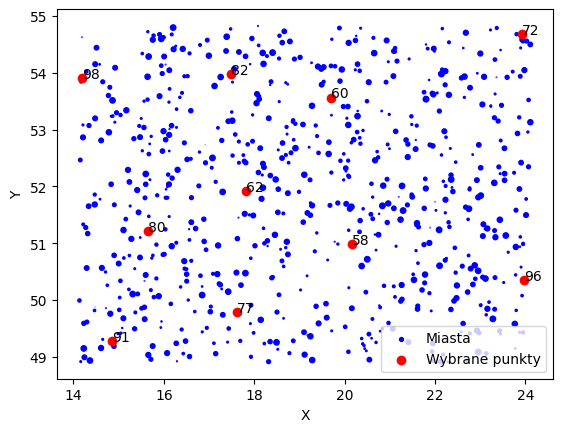

In [27]:
# Współrzędne miast
cities_x = [point[1] for point in data]
cities_y = [point[2] for point in data]

# Populacje miast
populations = [((point[3]*point[3])/25000000000000) for point in data]

# Współrzędne wybranych punktów
selected_x = [data[i-1][1] for i in selected_points]
selected_y = [data[i-1][2] for i in selected_points]

# Skalowanie wielkości punktów proporcjonalnie do populacji
scale_factor = 100  # Wielkość punktów będzie pomnożona przez ten czynnik
sizes = [pop * scale_factor for pop in populations]

# Wykres
plt.scatter(cities_x, cities_y, s=sizes, color='blue', label='Miasta')
plt.scatter(selected_x, selected_y, color='red', label='Wybrane punkty')

# Oznaczenie punktów na wykresie
for i, txt in enumerate(selected_points):
    plt.annotate(txt, (selected_x[i], selected_y[i]))

# Etykiety osi
plt.xlabel('X')
plt.ylabel('Y')

# Legenda
plt.legend()

# Wyświetlenie wykresu
plt.show()


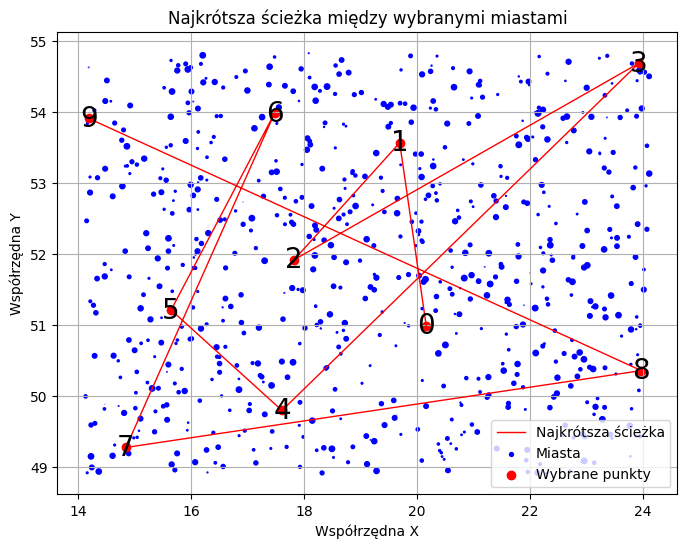

In [30]:
shortest_path = tour
# Tworzenie list współrzędnych dla wybranych punktów
x_coords = [data[i-1][1] for i in shortest_path]
y_coords = [data[i-1][2] for i in shortest_path]

# Tworzenie wykresu
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, color='red', linestyle='-', linewidth=1, label='Najkrótsza ścieżka')

# Dodawanie numerów krawędzi
for i, city in enumerate(shortest_path):
    x = data[city-1][1]
    y = data[city-1][2]
    plt.text(x, y, str(i), color='black', fontsize=20, verticalalignment='center', horizontalalignment='center')

# Współrzędne miast
cities_x = [point[1] for point in data]
cities_y = [point[2] for point in data]

# Populacje miast
populations = [((point[3]*point[3])/25000000000000) for point in data]

# Współrzędne wybranych punktów
selected_x = [data[i-1][1] for i in selected_points]
selected_y = [data[i-1][2] for i in selected_points]

# Skalowanie wielkości punktów proporcjonalnie do populacji
scale_factor = 100  # Wielkość punktów będzie pomnożona przez ten czynnik
sizes = [pop * scale_factor for pop in populations]

# Wykres
plt.scatter(cities_x, cities_y, s=sizes, color='blue', label='Miasta')
plt.scatter(selected_x, selected_y, color='red', label='Wybrane punkty')
plt.xlabel('Współrzędna X')
plt.ylabel('Współrzędna Y')
plt.title('Najkrótsza ścieżka między wybranymi miastami')
plt.legend()
plt.grid(True)
plt.show()